In [1]:
from pyhive import hive

import yaml
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, cross_val_predict, KFold, LeaveOneOut
from sklearn.utils.validation import column_or_1d
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import EasyEnsemble
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
import scikitplot as skplt
from sklearn import tree

from matplotlib.font_manager import FontProperties

In [ ]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/path/to/application/app/folder')

#import file

### Load Data

In [ ]:
# Set up the connector
host = '10.129.77.190'
port = 10000
username = 'cdp_jupyter'
password = 'C34r5tkn@1qe'
auth = 'CUSTOM'
database = 'marketing_modeling'

hc = hive.Connection(host = host, port = port, username = username, password = password, auth = auth, database = database)

In [ ]:
# for production, fetch data from database
# data = pd.read_sql('SELECT mobile,...... FROM mm_big_wide_info, hc)

In [4]:
# for training,already finish feature preparation and feature engineering offline, fetch data directly
data = pd.read_csv('/home/mam_jupyter/jupyter_dir/artefact/leads_scoring_model/EDA/model_autohome/wide_info_auto_select.csv',index_col = 0)
#wide_info_auto_trans = wide_info_auto_trans.drop('Unnamed: 0',axis = 1)
data.head()

,d_fir_trail_weekday,d_last_reservation_time_weekday,d_fir_dealfail_d_weekday,d_fir_visit_time_weekday,d_last_dealfail_d_weekday,d_fir_leads_time_month,d_fir_card_time_month,d_fir_visit_time_month,d_fir_trail_month,d_last_reservation_time_month,...,h_config_prefer16,h_config_prefer18,h_level_cat,c_MGHS,c_MGZS,c_MG6,c_vertical_media,c_leads_source_nums,c_city_level,d_deal_flag
mobile,,,,,,,,,,,,,,,,,,,,,
13000096666,0.0,0.0,1.0,NaN,3.0,2.0,2,NaN,NaN,NaN,...,1.0,1.0,SUV,0.0,0.0,0.0,1.0,1.0,五线城市,0
13001849160,0.0,0.0,1.0,NaN,1.0,2.0,2,NaN,NaN,NaN,...,1.0,1.0,轿车,0.0,0.0,1.0,1.0,1.0,三线城市,0
13002293217,0.0,0.0,1.0,NaN,1.0,2.0,2,NaN,NaN,NaN,...,1.0,1.0,轿车,0.0,1.0,1.0,1.0,1.0,NaN,0
13003062562,0.0,0.0,1.0,NaN,2.0,3.0,3,NaN,NaN,NaN,...,0.0,0.0,轿车,0.0,0.0,1.0,1.0,1.0,二线城市,0
13003129070,0.0,0.0,1.0,NaN,1.0,1.0,1,NaN,NaN,NaN,...,1.0,0.0,MPV,0.0,0.0,0.0,1.0,1.0,一线城市,0


In [5]:
data.shape

(162254, 87)

### Model Tuning

In [6]:
# split data into features and classification result
y = data['d_deal_flag']
X = data.drop(['d_deal_flag'],axis=1)

#### Drop columns with high missing rate

In [7]:
missing_rate = []
for col in list(X.columns):
    miss_rate = float(X[col].isnull().sum())/float(len(X))
    missing_rate.append(miss_rate)

missing_rate = pd.DataFrame(missing_rate, columns = ['missing_rate'])
missing_rate['feature'] = list(X.columns)
missing_rate.set_index('feature', drop = True).sort_values(by = ['missing_rate'], ascending = False)

missing_rate['missing_rate'].mean()

0.24937192934076088

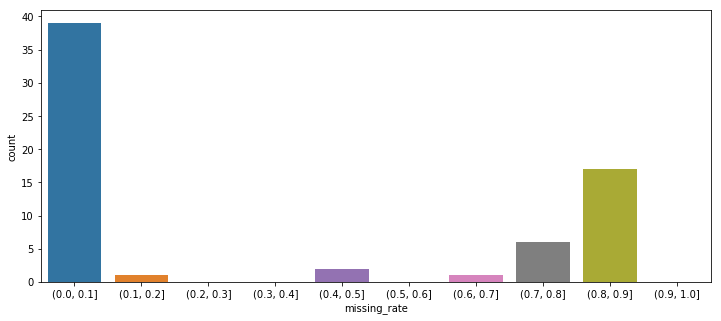

In [8]:
# missing rate distribution
plt.figure(figsize=(12, 5))
sns.countplot(pd.cut(missing_rate['missing_rate'], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
plt.show()

In [9]:
X = X.drop(list(missing_rate[missing_rate['missing_rate'] >= 0.85]['feature']),axis =1)

In [10]:
X.shape

(162254, 81)

#### One-hot encode categorical variables

In [ ]:
#['d_last_activity_dealf_diff', 'd_fir_activity_dealf_diff', 'd_avg_firleads_firvisit_diff', 'd_firleads_firvisit_diff']

In [11]:
# create dummy columns
dummy_col = ['h_level', 'h_level_cat', 'h_volume', 'c_sex', 'c_city_level', 'h_produce_way', 'c_age', 'd_fir_sec_leads_diff',
'd_avg_leads_date', 'd_avg_visit_date', 'd_avg_fircard_firvisit_diff',  'd_fircard_firvisit_diff',
 'd_last_dfail_dealf_diff', 'd_dealf_lastvisit_diff', 'd_firlead_dealf_diff', 'd_lastlead_dealf_diff', 
'd_dealf_firvisit_diff', 'd_lasttrail_dealf_diff', 'd_leads_dtbt_coincide',
'd_leads_dtbt_ppt', 'd_deal_fail_ppt', 'h_focusing_avg_diff', 'h_focusing_max_diff', 'd_leads_dtbt_count', 'd_leads_dtbt_level_1', 
'd_leads_count', 'd_trail_book_tll', 'h_model_nums', 'd_visit_ttl', 'd_activity_ttl', 'h_ttl_inquiry_time','d_card_ttl']
X = pd.get_dummies(data = X, columns = dummy_col)

In [12]:
X.shape

(162254, 259)

In [13]:
max_pop = []
for col in list(X.columns):
    pop = round(X[col].value_counts(normalize = True).max(),2)
    max_pop.append(pop)

max_pop_rate = pd.DataFrame(max_pop, columns = ['pop_rate'])
max_pop_rate['feature'] = list(X.columns)
max_pop_rate.set_index('feature', drop = True).sort_values(by = ['pop_rate'], ascending = False)

,pop_rate
feature,
"d_card_ttl_(9.0, 10.0]",1.00
"d_leads_dtbt_count_(7.0, 8.0]",1.00
"d_leads_dtbt_count_(10.0, 20.0]",1.00
"d_deal_fail_ppt_(0.0, 0.1]",1.00
"d_leads_dtbt_ppt_(0.01, 0.1]",1.00
"d_leads_dtbt_coincide_(0.0, 0.01]",1.00
"d_lasttrail_dealf_diff_(9.0, 10.0]",1.00
"d_lasttrail_dealf_diff_(8.0, 9.0]",1.00
"d_lasttrail_dealf_diff_(7.0, 8.0]",1.00


In [14]:
# remove columns with highly unbalanced distribution
X = X.drop(['c_sex_性别为女性|性别为男性', 'c_sex_性别为男性|性别为女性'] + \
           list(max_pop_rate[max_pop_rate['pop_rate'] >= 0.85]['feature']), axis = 1)

In [15]:
X.shape

(162254, 73)

In [16]:
zero_pop = []
for col in list(X.columns):
    z_pop = float(len(X[X[col]==0]))/float(len(X))
    zero_pop.append(z_pop)

zero_pop_rate = pd.DataFrame(zero_pop, columns = ['zero_pop_rate'])
zero_pop_rate['feature'] = list(X.columns)
zero_pop_rate.set_index('feature', drop = True).sort_values(by = ['zero_pop_rate'], ascending = False)

,zero_pop_rate
feature,
"h_model_nums_(6.0, 22.0]",0.838291
c_city_level_二线城市,0.835597
h_volume_1.7-2.0L,0.828343
c_city_level_三线城市,0.826463
c_sex_性别为男性,0.825705
"d_leads_count_(1.0, 2.0]",0.820306
"d_leads_count_(2.0, 3.0]",0.819240
"d_leads_dtbt_count_(1.0, 2.0]",0.817564
d_avg_visit_dtbt_count,0.812831


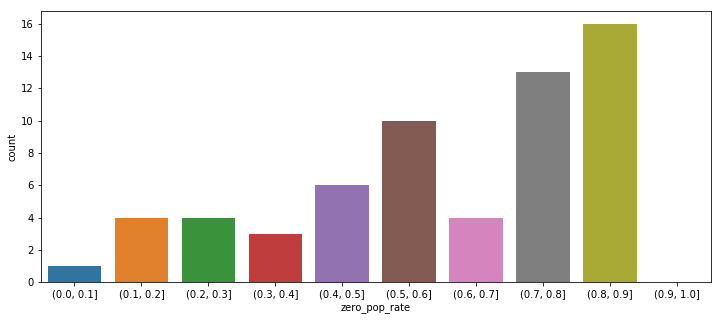

In [17]:
# missing rate distribution
plt.figure(figsize=(12, 5))
sns.countplot(pd.cut(zero_pop_rate['zero_pop_rate'], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
plt.show()

#### Impute missing value

Impute with constant: 0.5

In [18]:
# Impute missing value with 0.5
X = X.fillna(0.5)

#X = X.fillna({col:value,col2:value})

#imp_zero = SimpleImputer(strategy = 'constant', fill_value=0.5)
#X = imp_zero.fit_transform(X)

Impute using KNN

In [ ]:
# Impute missing value with k nearest neighbors
imp_knn = fancyimpute.KNN(k=100)
X = imp_knn.fit_transform(X)

#### Sampling Data

Oversampling

In [19]:
# oversample with ADASYN
seed = 123
X_res, y_res = ADASYN(random_state = seed).fit_resample(X, y)

#### PCA

In [20]:
pca = PCA()

pca.fit(X_res)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'explained_variance_')

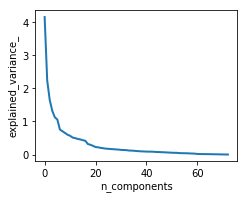

In [21]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [22]:
pca = PCA(n_components=30)
X_res = pca.fit_transform(X_res)

In [23]:
pd.DataFrame(pca.components_,columns = pd.DataFrame(X).columns)

,d_fir_trail_weekday,d_last_reservation_time_weekday,d_fir_visit_time_weekday,d_last_dealfail_d_weekday,d_fir_leads_time_month,d_fir_card_time_month,d_fir_visit_time_month,d_fir_trail_month,d_last_reservation_time_month,d_fir_dealfail_d_month,...,"d_leads_dtbt_level_1_(2.0, 3.0]","d_leads_count_(0.0, 1.0]","d_leads_count_(1.0, 2.0]","d_leads_count_(2.0, 3.0]","h_model_nums_(1.0, 6.0]","h_model_nums_(6.0, 22.0]","h_ttl_inquiry_time_(0.0, 1.0]","d_card_ttl_(0.0, 1.0]","d_card_ttl_(1.0, 2.0]","d_card_ttl_(2.0, 3.0]"
0,0.185736,0.092022,0.148285,-0.002963,0.136670,0.145307,0.235789,0.790359,0.115871,0.055899,...,0.017913,-0.074834,-0.001550,0.005143,0.005524,-0.006520,0.001018,-0.088694,0.005302,0.015451
1,-0.036349,0.002086,-0.063345,0.025741,0.678536,0.624007,-0.056214,-0.153094,0.027157,0.213261,...,-0.001110,0.020359,0.016165,0.001281,-0.017396,0.019092,-0.020562,0.003326,0.008081,0.002311
2,-0.024127,-0.001384,0.081556,0.037515,0.032999,0.003645,0.076664,-0.343811,-0.009674,0.189018,...,0.119611,-0.257026,0.029840,0.093070,0.023399,-0.028605,0.008120,-0.246494,0.023929,0.106326
3,0.007726,0.027945,0.023758,0.003005,-0.048529,-0.050814,0.051091,-0.170965,0.038195,-0.045622,...,0.055431,-0.133838,0.024460,0.042187,-0.109627,0.119439,-0.100167,-0.106172,0.013293,0.049702
4,0.013889,0.009345,0.119246,-0.063055,-0.000118,0.062002,0.209624,-0.149201,0.022506,-0.219133,...,-0.086221,0.038748,-0.023888,-0.085309,-0.137160,0.145299,-0.134147,0.053011,-0.017600,-0.074189
5,0.057903,0.124568,-0.260452,0.083644,-0.080338,-0.116955,-0.351292,0.293182,0.155478,0.127220,...,0.072992,-0.074019,0.035245,0.076339,-0.090148,0.102812,-0.054600,-0.038044,0.010923,0.068706
6,-0.043406,-0.027559,-0.088435,0.113729,-0.109503,-0.055242,-0.082921,-0.048496,-0.034378,0.136828,...,-0.063798,0.009031,-0.046186,-0.071468,0.043909,-0.050724,0.027702,0.041210,-0.040026,-0.054092
7,-0.028375,-0.057592,0.011818,-0.139066,0.048159,0.081752,-0.004979,0.071010,-0.086064,-0.055758,...,-0.045099,0.025686,0.012703,-0.035150,-0.066207,0.050756,-0.044113,0.036497,0.016417,-0.029294
8,-0.023983,0.016007,-0.037945,-0.284940,0.082248,0.111481,0.042307,0.051968,0.008087,-0.449798,...,0.063102,-0.140807,0.119168,0.077040,0.054826,-0.049675,0.033697,-0.115275,0.095685,0.072406
9,0.035376,0.073531,-0.146832,-0.148889,0.160014,0.070004,-0.191975,0.005263,0.075533,-0.350499,...,0.068492,0.088328,-0.183094,0.019170,0.000906,-0.001672,0.009731,0.116264,-0.206761,0.016443


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.6, random_state = 0)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, train_size = 0.5, random_state = 0)
print [i.shape for i in [X_train, X_test, X_validate, y_train, y_test, y_validate]]

Undersampling

#### Try Model 1 - Random Forest

In [25]:
parameters = [{ 'n_estimators':[10,5],
               'max_depth':[3],
               'min_samples_split':[700,900,1000,1100],
               'min_samples_leaf':[1000]}]

# Use grid-search to find the best hyperparameters
RF_Classification = GridSearchCV(estimator = RandomForestClassifier(criterion = 'entropy', n_jobs = -1,random_state=0), 
                                 param_grid = parameters,
                                 cv = 10, # 10-fold cross validation
                                 scoring = 'recall') # define the metric we would like to use for model evaluation

RF_Classification.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 5], 'min_samples_split': [700, 900, 1000, 1100], 'max_depth': [3], 'min_samples_leaf': [1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [125]:
def best_para_and_score(model):
    best_hyperparams = model.best_params_
    best_CV_score = model.best_score_
    print('Best hyerparameters:', best_hyperparams)
    print('Best CV accuracy', best_CV_score)

# Extract best hyperparameters and best CV score
best_para_and_score(RF_Classification)

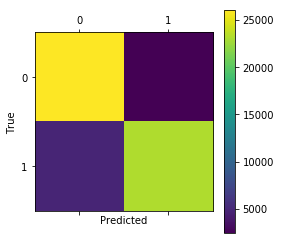

In [27]:
# Extract best model and evaluate test set accuracy
rf_best_model = RF_Classification.best_estimator_
rf_pred = rf_best_model.predict_proba(X_test)
rf_pred_round = np.where(np.array([prob[1] for prob in rf_pred]) > 0.5, 1, 0)

print 'Accuracy of test set:', accuracy_score(y_test, rf_pred_round)
# return model performance matrics
print(classification_report( y_true = y_test, y_pred = rf_pred_round))
print(confusion_matrix( y_true = y_test, y_pred = rf_pred_round))

rf_cm = confusion_matrix( y_true = y_test, y_pred = rf_pred_round)
plt.matshow(rf_cm)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [323]:
joblib.dump(rf_best_model, 'rf_model_auto.pkl')

['rf_model_auto.pkl']

In [324]:
joblib.dump(pca, 'pca_auto.pkl')

['pca_auto.pkl']

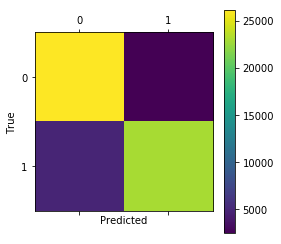

In [28]:
# Extract best model and evaluate test set accuracy
rf_pred_val = rf_best_model.predict_proba(X_validate)
rf_pred_val_round = np.where(np.array([prob[1] for prob in rf_pred_val]) > 0.5, 1, 0)

print 'Accuracy of validatio set:', accuracy_score(y_validate, rf_pred_val_round)
# return model performance matrics
print(classification_report( y_true = y_validate, y_pred = rf_pred_val_round))
print(confusion_matrix( y_true = y_validate, y_pred = rf_pred_val_round))

rf_cm = confusion_matrix( y_true = y_validate, y_pred = rf_pred_val_round)
plt.matshow(rf_cm)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

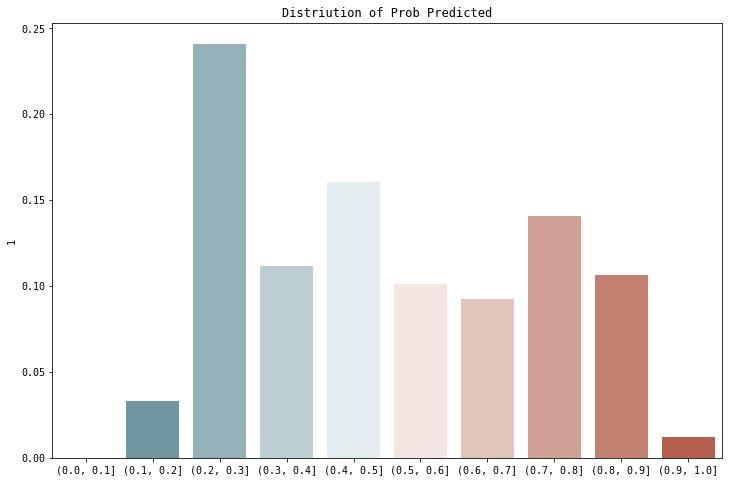

In [281]:
# socre distributio
dist = pd.DataFrame(pd.cut(pd.DataFrame(rf_pred)[1], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])\
                    .value_counts(normalize = True))
plt.figure(figsize=(12, 8))
sns.barplot(dist.index, dist[1], palette = sns.diverging_palette(220, 20, n = 10)).set_title('Distriution of Prob Predicted')
plt.show()

In [70]:
#score distribution for two classes
y_pred_class_1 = rf_pred[np.array([i[1] for i in zip(X_test,y_test)]) == 1]
y_pred_class_0 = rf_pred[np.array([i[1] for i in zip(X_test,y_test)]) == 0]

y_pred_class_1_dist = pd.DataFrame(pd.DataFrame([round(i,1) for i in pd.DataFrame(y_pred_class_1)[1]])[0].value_counts(normalize = True))
y_pred_class_0_dist = pd.DataFrame(pd.DataFrame([round(i,1) for i in pd.DataFrame(y_pred_class_0)[1]])[0].value_counts(normalize = True))

plt.figure(figsize=(12, 8))
sns.lineplot(y_pred_class_1_dist.index, y_pred_class_1_dist[0], c = 'CadetBlue')
sns.lineplot(y_pred_class_0_dist.index, y_pred_class_0_dist[0], c = 'LightCoral')
plt.legend(labels=['Actual Dealed','Actual Failed'])
plt.show()

In [188]:
# 对系数进行可视化
X = X.rename(columns = {"d_fir_trail_weekday":"d_have_trail",
                   "d_last_reservation_time_weekday":"d_have_reservation",
                   "d_fir_dealfail_d_weekday":"d_have_dealfail",
                        'h_level_紧凑型车':'h_level_Compactcar',
                       'h_level_紧凑型SUV':'h_level_CompactSUV',
                       'c_sex_性别为男性':'c_gender_Male',
                       'h_produce_way_合资':'h_produce_way_joint',
                       'c_city_level_二线城市':'c_city_level_tier2',
                       'h_level_cat_轿车':'h_car_level_car',
                       'c_city_level_新一线城市':'c_city_level_newtier1'})

In [320]:
df_cm.index

Index([u'd_have_trail', u'd_have_reservation', u'd_fir_visit_time_weekday',
       u'd_last_dealfail_d_weekday', u'd_fir_leads_time_month',
       u'd_fir_card_time_month', u'd_fir_visit_time_month',
       u'd_fir_trail_month', u'd_last_reservation_time_month',
       u'd_fir_dealfail_d_month', u'd_last_dealfail_d_month',
       u'd_avg_visit_dtbt_count', u'd_visit_dtbt_count',
       u'd_leads_car_model_count', u'd_leads_car_model_type', u'h_have_car',
       u'h_compete_car_num_d90', u'h_func_prefer1', u'h_func_prefer5',
       u'h_car_type_prefer1', u'h_car_type_prefer3', u'h_config_prefer2',
       u'h_config_prefer3', u'h_config_prefer6', u'h_config_prefer7',
       u'h_config_prefer11', u'h_config_prefer14', u'h_config_prefer16',
       u'h_config_prefer18', u'c_MGHS', u'c_MGZS', u'c_MG6',
       u'h_level_CompactSUV', u'h_level_Compactcar', u'h_level_cat_SUV',
       u'h_car_level_car', u'h_volume_1.1-1.6L', u'h_volume_1.7-2.0L',
       u'c_gender_Male', u'c_city_level_tier3', 

Text(0.5,1,'PCA Key Components')

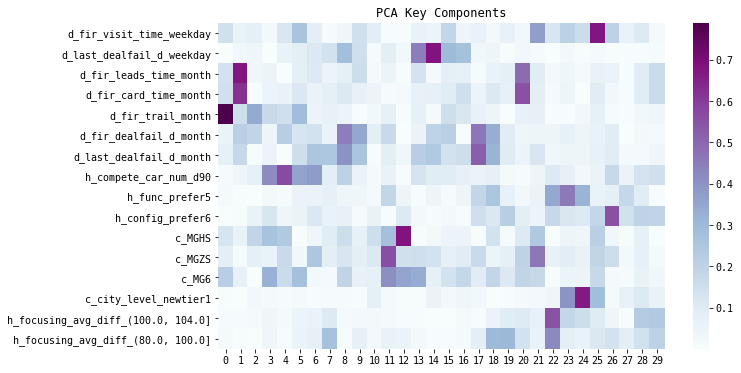

In [214]:
#coding:utf-8
df_cm = pd.DataFrame(np.abs(pca.components_), columns=X.columns).transpose()
plt.figure(figsize = (10,6))
ax = sns.heatmap(df_cm[df_cm.max(axis = 1) >= 0.4], annot=False, cmap="BuPu")
ax.yaxis.set_tick_params(labelsize = 10)
ax.xaxis.set_tick_params(labelsize = 10)
plt.title('PCA Key Components')
#plt.savefig('factorAnalysis.png', dpi=200)

Text(0.5,1,'PCA')

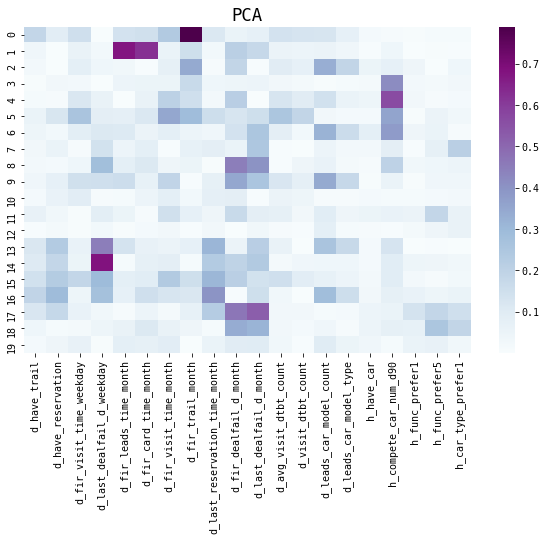

In [206]:
# 对系数进行可视化
df_cm = pd.DataFrame(np.abs(pca.components_)[:20,:20], columns=X.columns[:20])
plt.figure(figsize = (10,6))
ax = sns.heatmap(df_cm, annot=False, cmap="BuPu")
# 设置y轴的字体的大小
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=10)
plt.title('PCA', fontsize='xx-large')

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text xticklabel objects>)

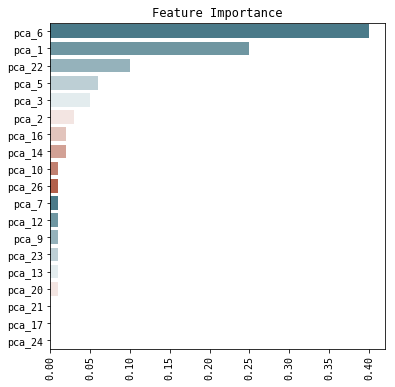

In [268]:
importance = pd.DataFrame(rf_best_model.feature_importances_)
importance['rank'] = importance.index + 1
importance['rank'] = ['pca_'+ str(i) for i in importance['rank']]
importance = importance.sort_values(0,ascending=False)
plt.figure(figsize=(6, 6))
sns.barplot([round(i,2) for i in importance[0]][0:19], list(importance['rank'][0:19]),\
            palette = sns.diverging_palette(220, 20, n = 10)).set_title('Feature Importance')
plt.xticks(rotation = 90)

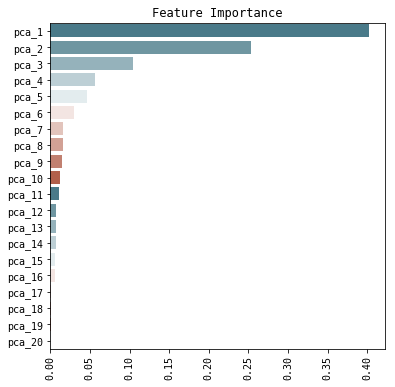

In [205]:
# feature importance
cols = ['pca_1','pca_2','pca_3','pca_4','pca_5','pca_6','pca_7','pca_8','pca_9','pca_10','pca_11','pca_12','pca_13','pca_14','pca_15','pca_16','pca_17','pca_18','pca_19','pca_20','pca_21','pca_22','pca_23','pca_24','pca_25','pca_26','pca_27','pca_28','pca_29','pca_30']
feature_importance_ordered = sorted(rf_best_model.feature_importances_, key=lambda tup: abs(tup), reverse=True)
feature_importance_ordered = list(zip(cols, feature_importance_ordered))
feature_importance_ordered_to_csv = pd.DataFrame(feature_importance_ordered).to_csv("rf_feature_importance.csv")

top_n_features = min(len(feature_importance_ordered), 20)

plt.figure(figsize=(6, 6))
sns.barplot([x[1] for x in feature_importance_ordered[:top_n_features]],[x[0] for x in feature_importance_ordered[:top_n_features]], \
            palette = sns.diverging_palette(220, 20, n = 10)).set_title('Feature Importance')
plt.xticks(rotation = 90) 
plt.show()

In [ ]:
feature_importance_ordered

In [ ]:
feature_importance

In [ ]:
list(range(1,21))

In [ ]:
feature_importance_ordered

In [ ]:
feature_importance_ordered 

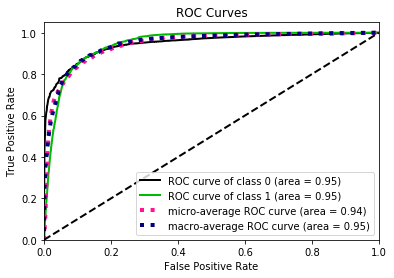

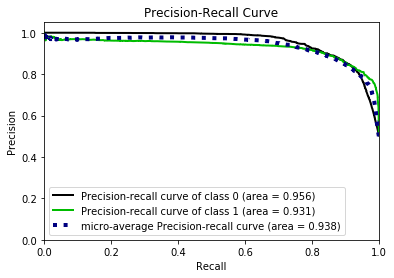

In [130]:
# plot Precision/Recall and ROC
skplt.metrics.plot_roc(y_test, rf_pred)
skplt.metrics.plot_precision_recall_curve(y_test, rf_pred, cmap = 'nipy_spectral')

In [ ]:
# demonstrate the tree
with open("rf_tree.dot", 'w') as f:
    f = tree.export_graphviz(rf_best_model[-1], out_file = f)

In [307]:
from sklearn.externals import joblib

# Save to file in the current working directory
joblib_file = "rf_model.pkl"
joblib.dump(rf_best_model, joblib_file)

['rf_model.pkl']

In [309]:
pca_file = 'pca.pkl'
joblib.dump(pca,pca_file)

['pca.pkl']

In [308]:
# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Y_predict = joblib_model.predict_proba(X_test)

In [316]:
pca_model = joblib.load(pca_file)
X_pca = pca.transform(X)

#### Try Model 2 - Catboost

In [ ]:
CB_Classification = cb.CatBoostClassifier(iterations = 500,
                                          learning_rate = 0.03,
                                          max_depth = 3, 
                                          l2_leaf_reg = 3,
                                          loss_function='Logloss',
                                          border_count=500, #数值特征分割数
                                          simple_ctr =["Borders:CtrBorderCount=500", "Counter:CtrBorderCount=500"]
                                          #ctr_border_count = 50
                                         ) #类别特征分割数

CB_Classification.fit(X_train,y_train)

In [ ]:
cb_pred = CB_Classification.predict_proba(X_test)
cb_pred_round = np.where(np.array([prob[1] for prob in cb_pred]) > 0.5, 1, 0)

print 'Accuracy of test set:', accuracy_score(y_test, cb_pred_round)
# return model performance matrics
print(classification_report( y_true = y_test, y_pred = cb_pred_round))
print(pd.crosstab(y_test, cb_pred_round, rownames = ['Actual'], colnames = ['Predicted']))

cb_cm = confusion_matrix( y_true = y_test, y_pred = cb_pred_round)
plt.matshow(cb_cm)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# socre distributio
plt.figure(figsize=(12, 5))
sns.countplot(pd.cut(pd.DataFrame(cb_pred)[1], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
plt.show()

In [ ]:
# feature importance
feature_importance = list(zip(pd.DataFrame(X).columns, CB_Classification.feature_importances_))
feature_importance_ordered = sorted(feature_importance, key=lambda tup: abs(tup[1]), reverse=True)

feature_importance_ordered_to_csv = pd.DataFrame(feature_importance_ordered).to_csv("cb_feature_importance.csv")

top_n_features = min(len(feature_importance_ordered), 20)

plt.figure(figsize=(12, 5))
plt.bar([x[0] for x in feature_importance_ordered[:top_n_features]], 
           [x[1] for x in feature_importance_ordered[:top_n_features]])
plt.xticks(rotation = 90) 
plt.show()

In [ ]:
[X[i[0]].value_counts(normalize = True) for i in feature_importance_ordered[:10]]

In [ ]:
# plot Precision/Recall and ROC
skplt.metrics.plot_precision_recall_curve(y_test, cb_pred)
skplt.metrics.plot_roc(y_test, cb_pred)

#### Try Model 3 - LightGBM

#### Try Model 4 - XGBoost

#### Model Performance (ref.)

In [ ]:
# Plot metrics
skplt.metrics.plot_lift_curve(y_true = y_test, y_probas = prob_predictions)

skplt.metrics.plot_precision_recall(y_true = y_test, y_probas = prob_predictions)

skplt.metrics.plot_roc(y_true = y_test, y_probas = prob_predictions)

skplt.metrics.plot_cumulative_gain(y_true = y_test, y_probas = prob_predictions)

sk.metrics.plot_precision_recall_curve(estimator = model, X = X_test, y = y_test)